# Study Deorbiting Model vs TLE Data
The purpose of this study is to check whether its possible to predict the deorbiting time of a cubesat in comparison with the public TLE data of many cubesats which have already deorbited.

In [2]:
import sys
sys.path.append("../../src")
import auxiliary, coordinates, constants, models
from maneuvers import Maneuvers
import numpy as np
import matplotlib.pyplot as plt
import os
import requests
import datetime
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

## Download TLEs Historical Data
The data was downloaded from https://www.space-track.org. The website has an API which enables to download data programatically. However, user account registration is needed in order to use it and the ToS indicate to keep the information request limited to low volume.  
A request usually requires knowing the NORAD CAT ID.

This kind of historical TLEs can also be requested at http://celestrak.com/norad/archives/request.php.

A lot of data on NanoSats has been aggregated by http://www.nanosats.eu, which can be found in detail in https://airtable.com/shrafcwXODMMKeRgU

In [ ]:
# Login
loginRequest = requests.post("https://www.space-track.org/ajaxauth/login", 
                              data = {'identity':'ricardo.ramos@ing.uchile.cl',
                                      'password':'453123KO453123KO'})

In [ ]:
# Request information through the API
r = requests.get("https://www.space-track.org/basicspacedata/query/class/tle/EPOCH/2013-01-01--2018-11-24/NORAD_CAT_ID/40969/orderby/TLE_LINE1 ASC/format/tle",
                  cookies=loginRequest.cookies)
print(r)
with open("Historic_TLEs/ARC-1.txt","w",newline='\n') as f:
    f.write(r.text)

## Parse Cubesats Historical TLEs

In [3]:
def getSatHistoricalData(TleHistoricalFile):
    satCoes = []
    satDates = []
    satAltitudes = []
    satBallistic = []
    with open(TleHistoricalFile,"r") as f:
        while True:
            line1 = f.readline()
            line2 = f.readline()
            if line1 == "":
                break
            i = float(line2[8:16])*np.pi/180
            Omega = float(line2[17:25])*np.pi/180
            e = float("0."+line2[26:33])
            omega = float(line2[34:42])*np.pi/180
            M = float(line2[43:51])*np.pi/180

            for E in range(0,3600):
                E = E/10*np.pi/180
                if(abs(E-e*np.sin(E)-M) < 0.01):
                    break;
  
            nu = 2*np.arctan2((1+e)**0.5*np.sin(E/2),(1-e)**0.5*np.cos(E/2))

            n = float(line2[52:63])*2*np.pi/(60*60*24)
            a = (constants.mu_E/n**2)**(1/3)

            if int(line1[18:20]) < 60:
                year = int("20"+line1[18:20])
            else:
                year = int("19"+line1[18:20]) 

            coe = [a,e,i,omega,Omega,nu]
            date = datetime.datetime(year,1,1)+datetime.timedelta(days=float(line1[20:32]))
          
            # BSTAR has units of (earth radii)**-1
            # Air density reference: 0.1570 kg/m^2/Earth radii
            BSTAR = float(line1[53]+"0."+line1[54:59])*10**float(line1[59:61])
            B = BSTAR*2/0.1570

            satCoes.append(coe)
            satDates.append(date)
            satBallistic.append(B)
            r,v = coordinates.kep2cart(coe)
            altitude = np.linalg.norm(r)/1e3-constants.Re/1e3
            satAltitudes.append(altitude)
    satCoes = np.array(satCoes).reshape((-1,6))
    return satDates, satCoes, satAltitudes, satBallistic

In [13]:
sats2013 = ["Black Knight 1",
            "CAPE-2",
            "ChargerSat-1",
            "COPPER",
            "DragonSat 1",
            "KYSAT II",
            "NPS-SCAT",
            "PhoneSat 2.4a",
            "SwampSat"]
sats2016 = ["BEESAT-4",
            "Swayam COEP"]
sats2017 = ["SUCHAI",
            "Nayif-1",
            "STEP-1"]


satsData2013 = {}
satsData2016 = {}
satsData2017 = {}
for sat in sats2013:
    print(sat)
    satsData2013[sat] = {}
    satsData2013[sat]["datetime"], satsData2013[sat]["coe"], satsData2013[sat]["altitudes"], satsData2013[sat]["ballistic"] = getSatHistoricalData("Historic_TLEs/"+sat+".txt")
for sat in sats2016:
    print(sat)
    satsData2016[sat] = {}
    satsData2016[sat]["datetime"], satsData2016[sat]["coe"], satsData2016[sat]["altitudes"], satsData2016[sat]["ballistic"] = getSatHistoricalData("Historic_TLEs/"+sat+".txt")
for sat in sats2017:
    print(sat)
    satsData2017[sat] = {}
    satsData2017[sat]["datetime"], satsData2017[sat]["coe"], satsData2017[sat]["altitudes"], satsData2017[sat]["ballistic"] = getSatHistoricalData("Historic_TLEs/"+sat+".txt")

Black Knight 1
CAPE-2
ChargerSat-1
COPPER
DragonSat 1
KYSAT II
NPS-SCAT
PhoneSat 2.4a
SwampSat
BEESAT-4
Swayam COEP
SUCHAI
Nayif-1
STEP-1


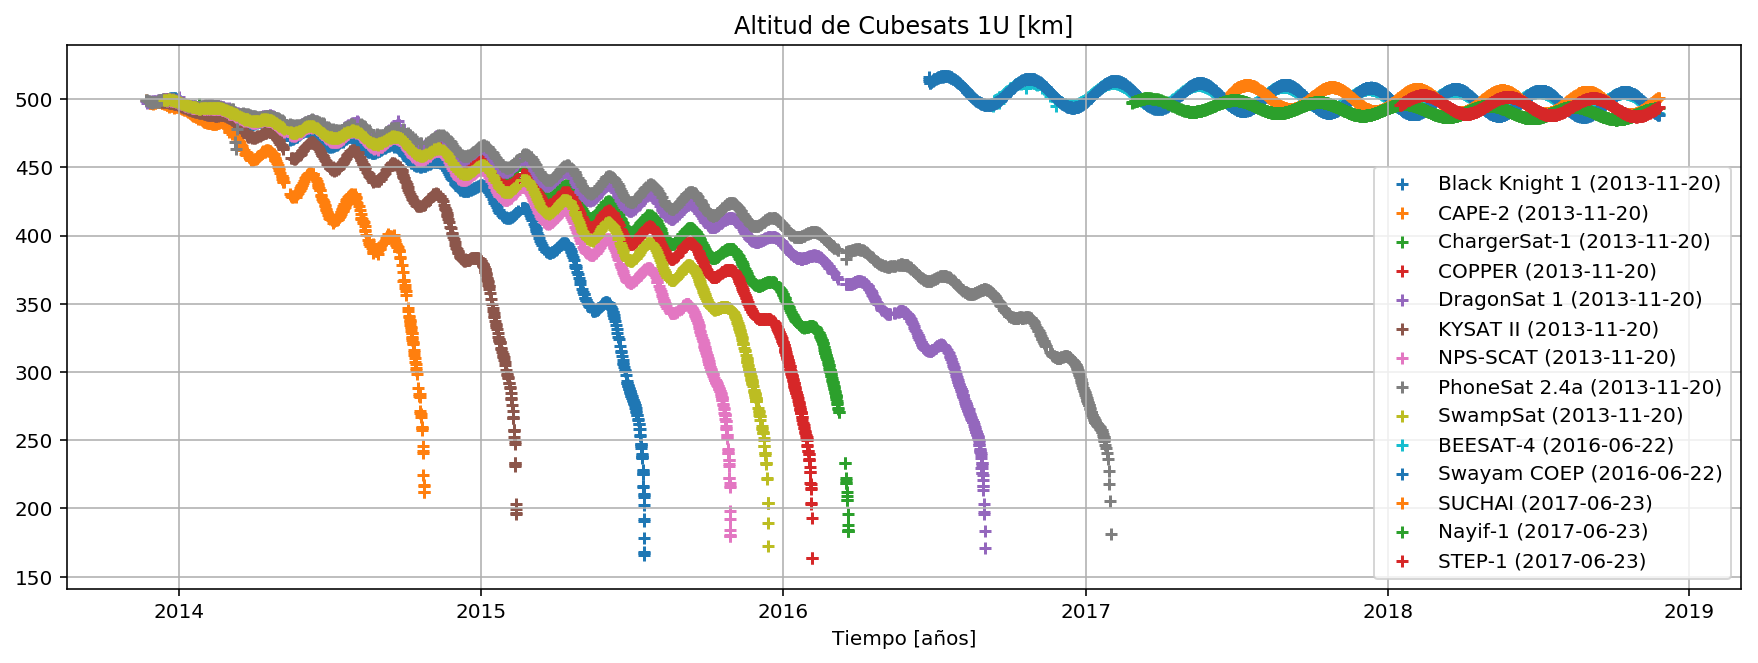

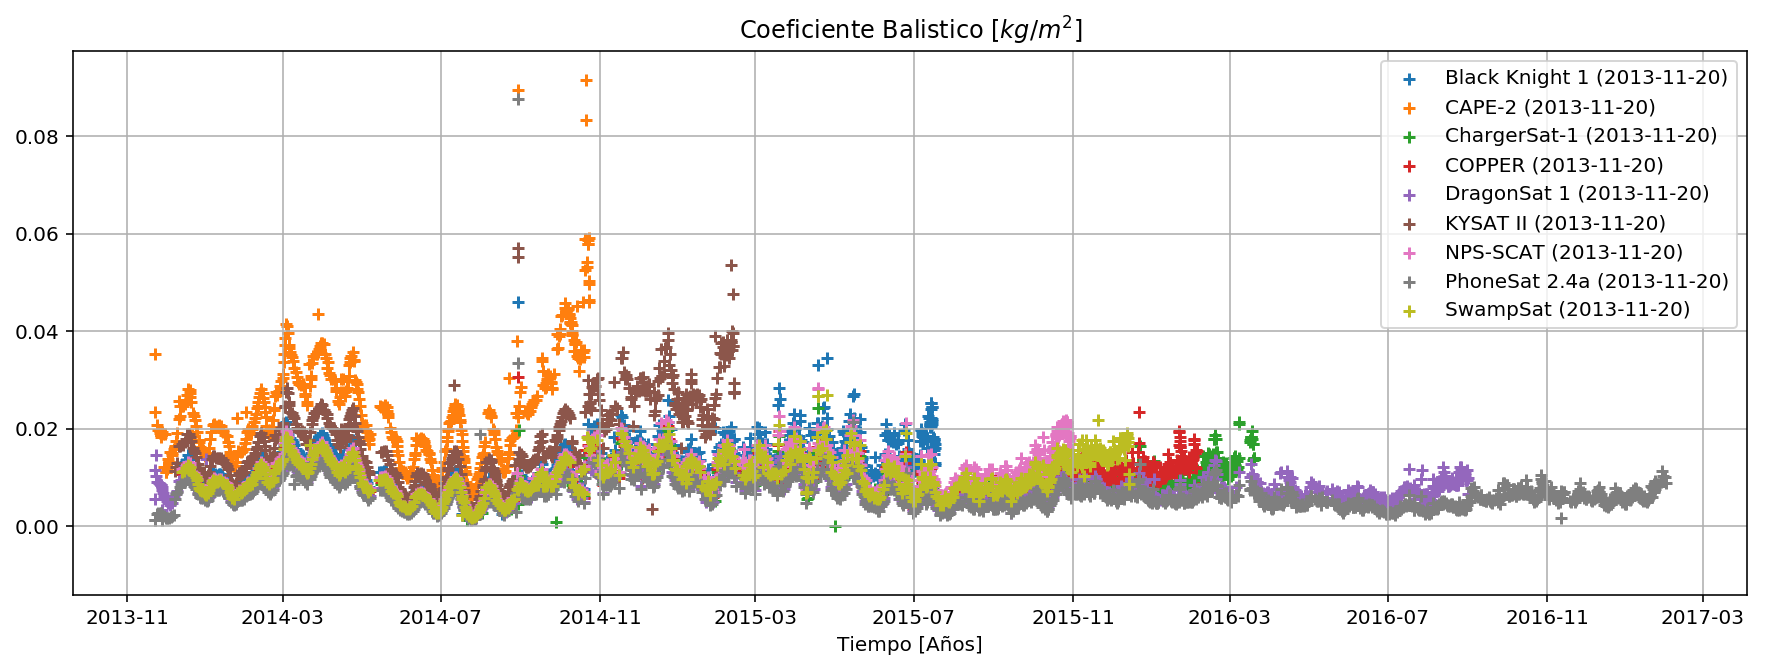

In [21]:
plt.figure(figsize=(15,5));
for sat in sats2013:    
    plt.scatter(satsData2013[sat]["datetime"],satsData2013[sat]["altitudes"],marker="+",label=sat+' (2013-11-20)')
for sat in sats2016:    
    plt.scatter(satsData2016[sat]["datetime"],satsData2016[sat]["altitudes"],marker="+",label=sat+' (2016-06-22)')
for sat in sats2017:    
    plt.scatter(satsData2017[sat]["datetime"],satsData2017[sat]["altitudes"],marker="+",label=sat+' (2017-06-23)')
plt.grid()
plt.title("Altitud de Cubesats 1U [km]")
plt.xlabel("Tiempo [años]")
plt.legend();

plt.figure(figsize=(15,5))
for sat in sats2013: 
    plt.scatter(satsData2013[sat]["datetime"],satsData2013[sat]["ballistic"],marker="+",label=sat+' (2013-11-20)')
plt.grid()
plt.title("Coeficiente Balistico [$kg/m^2$]")
plt.xlabel("Tiempo [Años]")
plt.legend();

<img src="http://www.stce.be/sites/default/files/field/image/Figure1.png" width="500" style="float:right">
In the previous figure is presented the data for the altitude and ballistic coefficient for 14 1U cubesats.
In the first figure, two distinct groups can be recognized:

1. The first one corresponds to the 1U cubesats launched by the Minotaur-1 rocket in 2013-11-20. These satellites were placed on the same orbit corresponding to a 500 km altitude circular orbit with 40.5° inclination.  
2. The second one corresponds to the 1U cubesats launched between 2016 and 2017, all within a sun synchronous, 500km circular orbit with 97.5° inclination.

It can be observed that even though the first group were all placed in the same orbit at roughly the same time, the deorbiting times differ considerably, reaching differences of more than two years.

Also, the deorbiting times of the first group are a lot smaller than in the second group. This is most likely due to the high solar activty period near 2015.


# Models vs Data of Tiangong-1 Space Station deorbiting
<img src="https://cdn.newsapi.com.au/image/v1/0b0e901c514428bffe0b1b614b1cb670" style="width:300px;float:left;margin-right:20px" />

Tiangong-1 was China's first prototype space station. It orbited Earth from September 2011 to April 2018, serving as both a manned laboratory and an experimental testbed to demonstrate orbital rendezvous and docking capabilities during its two years of active operational life.

In September, after conceding they had lost control over the station, officials speculated that the station would re-enter and burn up in the atmosphere late in 2017. According to the China Manned Space Engineering Office, Tiangong-1 started reentry over the southern Pacific Ocean, northwest of Tahiti, on 2 April 2018 at 00:15 UTC.

In [27]:
tiangongDates = []
tiangongCoes = []
tiangongAltitudes = []
tiangongBallistic = []
tiangongDates, tiangongCoes, tiangongAltitudes, tiangongBallistic = getSatHistoricalData("Historic_TLEs/Tiangong-1.txt")

i = 10
coe = tiangongCoes[i,:]
date = tiangongDates[0]
tiangongMass = 8506
tiangongArea = tiangongBallistic[i]*tiangongMass/2.2
print("Radial Area: ",np.pi*(3.35/2)**2)
print("TLE Area: ",tiangongArea)
tiangongModel = models.Spacecraft(tiangongMass,tiangongMass,tiangongArea)

tiangongManeuvers = Maneuvers(coe,tiangongModel,date,verbose=True)
tiangongManeuvers.addPerturbation("atmosphere")
tiangongManeuvers.propagate(60*60*24*365*1.52,60*10)

Radial Area:  8.814130888727863
TLE Area:  11.888206253618991
Propagating...from day  0.0  to  554.8000000000001
Day:0.0	Height: 369.96273502378443 km	Mass: 0.0
Day:8.454829902595654e-07	Height: 369.9635927242041 km	Mass: 0.0
Day:8.454829902595654e-07	Height: 369.96359272398615 km	Mass: 0.0
Day:1.6909659805191309e-06	Height: 369.9644504067665 km	Mass: 0.0
Day:1.6909659805191309e-06	Height: 369.9644504065495 km	Mass: 0.0
Day:0.0009414048732839239	Height: 370.90546786587873 km	Mass: 0.0
Day:0.0009414048732839239	Height: 370.90546940507835 km	Mass: 0.0
Day:11.001051866185799	Height: 374.37191195596756 km	Mass: 0.0
Day:11.001051866185799	Height: 374.3718339467226 km	Mass: 0.0
Day:13.00009448072001	Height: 356.688590913564 km	Mass: 0.0
Day:13.00009448072001	Height: 356.688893095932 km	Mass: 0.0
Day:17.00059935484498	Height: 373.9490065608369 km	Mass: 0.0
Day:17.00059935484498	Height: 373.94883625186424 km	Mass: 0.0
Day:24.000612588678194	Height: 368.19619767071583 km	Mass: 0.0
Day:24.000612

Day:490.0000443032577	Height: 274.14370003758 km	Mass: 0.0
Day:490.0000443032577	Height: 274.14481814626606 km	Mass: 0.0
Day:491.00040746404596	Height: 273.5826971016983 km	Mass: 0.0
Day:491.00040746404596	Height: 273.583836669812 km	Mass: 0.0
Day:492.00063344382716	Height: 273.01108805613313 km	Mass: 0.0
Day:492.00063344382716	Height: 273.0122466775924 km	Mass: 0.0
Day:493.00072636264196	Height: 272.43115822414495 km	Mass: 0.0
Day:493.00072636264196	Height: 272.4323347466681 km	Mass: 0.0
Day:497.0008900650166	Height: 270.4691644043885 km	Mass: 0.0
Day:497.0008900650166	Height: 270.47070865161254 km	Mass: 0.0
Day:502.00100217469753	Height: 268.7852944020918 km	Mass: 0.0
Day:502.00100217469753	Height: 268.7863891081726 km	Mass: 0.0
Day:503.00048138444805	Height: 268.33184038837163 km	Mass: 0.0
Day:503.00048138444805	Height: 268.33311718675776 km	Mass: 0.0
Day:513.0002596767607	Height: 258.9556142772194 km	Mass: 0.0
Day:513.0002596767607	Height: 258.95500847531764 km	Mass: 0.0
Day:517.00

------------MANEUVER REPORT-------------
----INITIAL CONDITIONS----
Date/Time:
  Initial Date: 2016-09-20 03:38:46

Spacecraft:
  Wet Mass: 		8506 kg
  Dry Mass: 		8506 kg
  Propellant Mass: 	0 kg
  Drag Area: 		11.888206253618991 m2
  Cd: 			2.2
  Cr: 			2

Thruster:
  Name/Model:		Generic Thruster
  Thrust (nominal):	0.1 N
  Isp (nominal):	720 s
  Power (nominal):	1 W

Solar Panels:
  Name/Model:			Generic Solar Panel
  Number of Panels:		1
  Individual Area:		0.010000000000000002 m2
  Total Power (nominal):	2.8000000000000007 W

Battery:
  Name/Model:		Generic Battery
  Cells Configuration:	8P-1S
  Voltage:		3.7 V
  Capacity:		7200 mAh
  Energy:		26.64 Wh
  Charge Power:		29.6 W
  Discharge Power:	29.6 W

Orbit:
  Semi-major axis (a): 		6745.429830379382 km
  Eccentricity (e): 		0.001574
  Inclination (i): 		42.7662 deg
  Argument of Perigee (omega): 	351.0529 deg
  RAAN (Omega): 		24.7762 deg
  True Anomaly (nu): 		103.88758 deg

----FINAL CONDITIONS----
Date/Time:
  Elapsed Time:	

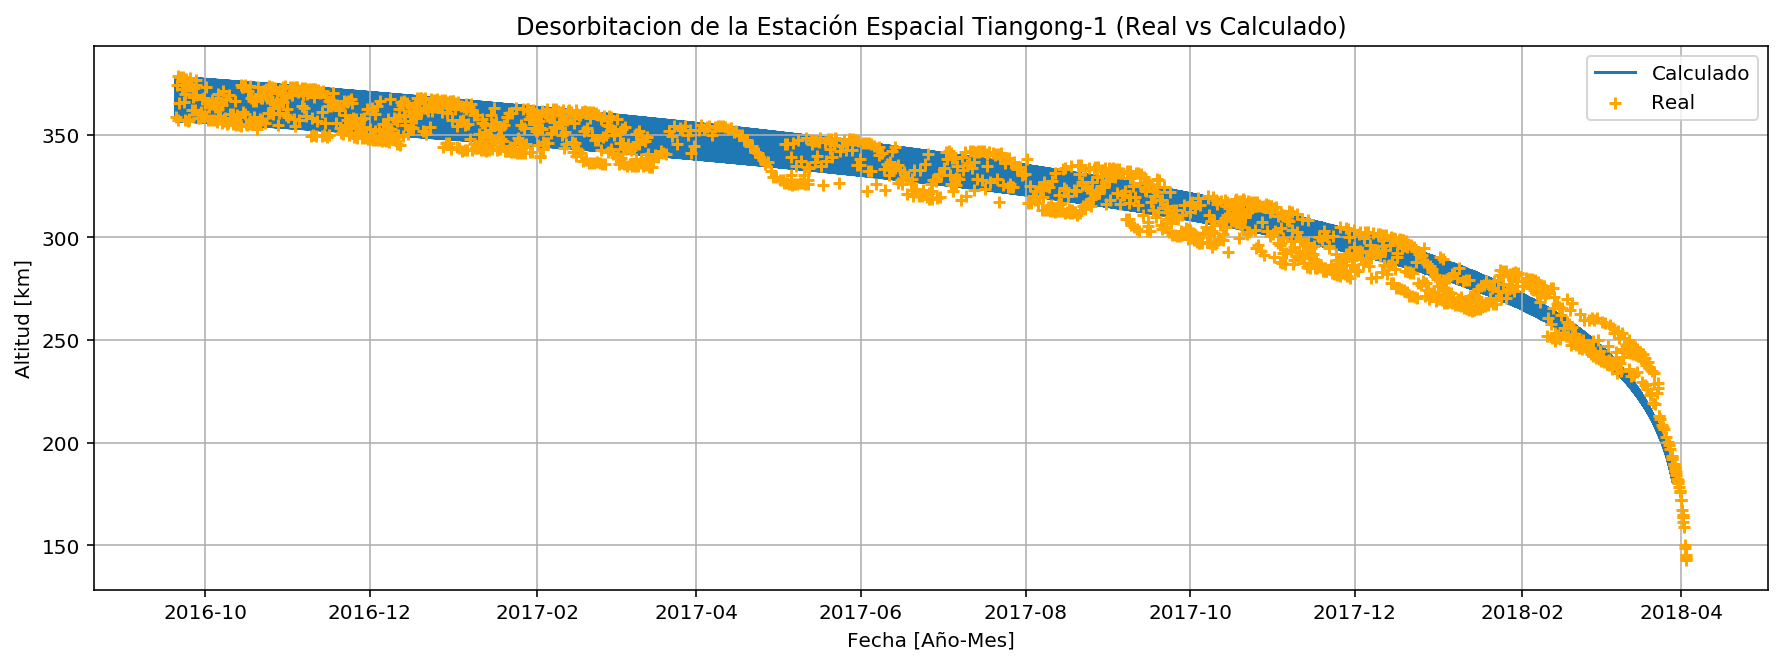

In [30]:
tiangongManeuvers.makeReport()
plt.figure(figsize=(15,5));
plt.title("Desorbitacion de la Estación Espacial Tiangong-1 (Real vs Calculado)")
plt.xlabel("Fecha [Año-Mes]")
plt.ylabel("Altitud [km]")
plt.plot(tiangongManeuvers.history.datetime,np.linalg.norm(tiangongManeuvers.history.r,axis=1)/1e3-constants.Re/1e3,zorder=1,label="Calculado")
plt.scatter(tiangongDates,tiangongAltitudes,marker="+",color="orange",zorder=2,label="Real");
plt.legend()
plt.grid()

The previous figure shows the altitude data of the Tiangong-1 Space Station along the simulated trajectory.
Even though it may seem as the model adjusts well within the data, it depends a lot on the almospheric model chosen to run the simulation. In this case the chosen atmospheric model corresponds to the MSISE90 model, tabulated for a mean solar activity period, which is a reasonable choice considering the deorbiting period took place between the years 2016-2018. 

When using other models, the deorbiting periods increase and decrease depending on the overall atmospheric density.

# SUCHAI
<img src="https://upload.wikimedia.org/wikipedia/commons/d/d2/SUCHAI.jpg" style="width:200px;float:left"/>
  
The Satellite of the University of Chile for Aerospace Investigation (SUCHAI) is the first chilean CubeSat developed by undergraduate students, engineers and professors of the Electrical Engineering, Physics and Mechanical Engineering Departments of the Faculty of Physical and Mathematical Sciences (FCFM) at University of Chile. The main goal is to learn the whole process of designing, building/integrating, launching and operating a picosatellite.

SUCHAI was placed in orbit by a PSLV (PSLV-C38) rocket from the ISRO, on June 23, 2017 at 9:30 local time. The satellite was placed on a 500km, 97.5° orbit

In [4]:
suchaiDates = []
suchaiCoes = []
suchaiAltitudes = []
suchaiBallistic = []
suchaiDates, suchaiCoes, suchaiAltitudes, suchaiBallistic = getSatHistoricalData("Historic_TLEs/SUCHAI.txt")

In [5]:
i = 0
coe = suchaiCoes[i,:]
date = suchaiDates[0]
suchaiMass = 1
suchaiArea = suchaiBallistic[i]*suchaiMass/2.2
print("TLE Area: ",suchaiArea)
suchaiModel = models.Spacecraft(suchaiMass,suchaiMass,suchaiArea)

#Harris Priester max
suchaiManeuvers = Maneuvers(coe,suchaiModel,date,verbose=True)
suchaiManeuvers.addPerturbation("atmosphere")
suchaiManeuvers.propagate(60*60*24*365*17.2,60*10)

TLE Area:  0.0005790387955993052
Propagating...from day  0.0  to  6278.0
Day:0.0	Height: 504.430649130065 km	Mass: 0.0
Day:8.462787487741391e-07	Height: 504.43119649499187 km	Mass: 0.0
Day:8.462787487741391e-07	Height: 504.4311964949053 km	Mass: 0.0
Day:1.6925574975482783e-06	Height: 504.4317438428942 km	Mass: 0.0
Day:1.6925574975482783e-06	Height: 504.4317438428048 km	Mass: 0.0
Day:0.0010389707535400103	Height: 505.08880037761105 km	Mass: 0.0
Day:0.0010389707535400103	Height: 505.0888016472813 km	Mass: 0.0
Day:7.000485782117523	Height: 501.3835302052088 km	Mass: 0.0
Day:7.000485782117523	Height: 501.382351793848 km	Mass: 0.0
Day:9.000558402570658	Height: 498.34824251632483 km	Mass: 0.0
Day:9.000558402570658	Height: 498.3476413434865 km	Mass: 0.0
Day:20.000298693089913	Height: 508.35643397036756 km	Mass: 0.0
Day:20.000298693089913	Height: 508.3569567493638 km	Mass: 0.0
Day:23.000499141729197	Height: 494.92830118954646 km	Mass: 0.0
Day:23.000499141729197	Height: 494.92775694158394 km	Ma

Day:626.0006965030364	Height: 492.4155381918419 km	Mass: 0.0
Day:626.0006965030364	Height: 492.3866521104509 km	Mass: 0.0
Day:641.0007179682979	Height: 496.43085022884515 km	Mass: 0.0
Day:641.0007179682979	Height: 496.4058225698341 km	Mass: 0.0
Day:689.0005838396387	Height: 487.92812424575726 km	Mass: 0.0
Day:689.0005838396387	Height: 487.9079398448765 km	Mass: 0.0
Day:712.0005383031321	Height: 495.0149180376567 km	Mass: 0.0
Day:712.0005383031321	Height: 494.9796186914593 km	Mass: 0.0
Day:784.0002601169791	Height: 496.4142253447706 km	Mass: 0.0
Day:784.0002601169791	Height: 496.38713467555027 km	Mass: 0.0
Day:786.0005281536254	Height: 488.319829679342 km	Mass: 0.0
Day:786.0005281536254	Height: 488.2894409129666 km	Mass: 0.0
Day:788.0007961902716	Height: 495.0481406774716 km	Mass: 0.0
Day:788.0007961902716	Height: 495.0152099070102 km	Mass: 0.0
Day:790.001064226918	Height: 489.6667007606132 km	Mass: 0.0
Day:790.001064226918	Height: 489.63215388522207 km	Mass: 0.0
Day:859.0000008312295	H

Day:1789.0009099519277	Height: 472.1598777154917 km	Mass: 0.0
Day:1789.0009099519277	Height: 472.14681957191044 km	Mass: 0.0
Day:1860.0001145928854	Height: 481.95067438398024 km	Mass: 0.0
Day:1860.0001145928854	Height: 481.9419343534345 km	Mass: 0.0
Day:1862.0003826295322	Height: 470.17434327033163 km	Mass: 0.0
Day:1862.0003826295322	Height: 470.1756349702822 km	Mass: 0.0
Day:1864.0006506661782	Height: 481.04308635353857 km	Mass: 0.0
Day:1864.0006506661782	Height: 481.03821570244804 km	Mass: 0.0
Day:1866.0009187028243	Height: 474.1261327460781 km	Mass: 0.0
Day:1866.0009187028243	Height: 474.10550601909773 km	Mass: 0.0
Day:1937.0001233437824	Height: 468.9685298544746 km	Mass: 0.0
Day:1937.0001233437824	Height: 468.9694185626581 km	Mass: 0.0
Day:1939.0003913804285	Height: 479.82059261481555 km	Mass: 0.0
Day:1939.0003913804285	Height: 479.8160560216112 km	Mass: 0.0
Day:1941.0006594170748	Height: 473.16242878233174 km	Mass: 0.0
Day:1941.0006594170748	Height: 473.1410549089387 km	Mass: 0.0


Day:3028.0003357026176	Height: 456.68090384740566 km	Mass: 0.0
Day:3028.0003357026176	Height: 456.66635928306357 km	Mass: 0.0
Day:3053.0006276430154	Height: 452.5369533889396 km	Mass: 0.0
Day:3053.0006276430154	Height: 452.51916903413365 km	Mass: 0.0
Day:3078.0009195834123	Height: 448.62421096380984 km	Mass: 0.0
Day:3078.0009195834123	Height: 448.62193883919156 km	Mass: 0.0
Day:3085.0002425925227	Height: 458.83845338220897 km	Mass: 0.0
Day:3085.0002425925227	Height: 458.8388800915461 km	Mass: 0.0
Day:3110.0005345329196	Height: 453.66070593429913 km	Mass: 0.0
Day:3110.0005345329196	Height: 453.6435126122935 km	Mass: 0.0
Day:3135.000826473317	Height: 447.26622874483934 km	Mass: 0.0
Day:3135.000826473317	Height: 447.2660417787358 km	Mass: 0.0
Day:3142.0001494824264	Height: 456.9469985381747 km	Mass: 0.0
Day:3142.0001494824264	Height: 456.944947848442 km	Mass: 0.0
Day:3160.0011184137143	Height: 453.4665591170965 km	Mass: 0.0
Day:3160.0011184137143	Height: 453.44902482707425 km	Mass: 0.0
Da

Day:4543.000922376455	Height: 409.7037283725627 km	Mass: 0.0
Day:4543.000922376455	Height: 409.7023248297004 km	Mass: 0.0
Day:4559.000222190987	Height: 410.3170790567212 km	Mass: 0.0
Day:4559.000222190987	Height: 410.31260876292924 km	Mass: 0.0
Day:4570.000720202546	Height: 412.752854400903 km	Mass: 0.0
Day:4570.000720202546	Height: 412.74607322859856 km	Mass: 0.0
Day:4586.000020017079	Height: 409.14662146408017 km	Mass: 0.0
Day:4586.000020017079	Height: 409.1428520231266 km	Mass: 0.0
Day:4597.000518028638	Height: 415.2294444183502 km	Mass: 0.0
Day:4597.000518028638	Height: 415.22936397233605 km	Mass: 0.0
Day:4608.001016040197	Height: 408.1120645429511 km	Mass: 0.0
Day:4608.001016040197	Height: 408.1085959906131 km	Mass: 0.0
Day:4624.000315854731	Height: 412.24953334748466 km	Mass: 0.0
Day:4624.000315854731	Height: 412.24470547050146 km	Mass: 0.0
Day:4635.00081386629	Height: 405.95852296302934 km	Mass: 0.0
Day:4635.00081386629	Height: 405.9584787689149 km	Mass: 0.0
Day:4649.00097143495

Day:5406.000433979646	Height: 369.63256537239624 km	Mass: 0.0
Day:5406.000433979646	Height: 369.63100616985184 km	Mass: 0.0
Day:5461.001137833321	Height: 365.9798579558441 km	Mass: 0.0
Day:5461.001137833321	Height: 365.97855549367426 km	Mass: 0.0
Day:5466.001084756942	Height: 370.24058236143736 km	Mass: 0.0
Day:5466.001084756942	Height: 370.24036776334236 km	Mass: 0.0
Day:5471.001031680561	Height: 367.31082463693434 km	Mass: 0.0
Day:5471.001031680561	Height: 367.30912415290254 km	Mass: 0.0
Day:5476.000978604182	Height: 364.317711304144 km	Mass: 0.0
Day:5476.000978604182	Height: 364.31704004615915 km	Mass: 0.0
Day:5481.000925527802	Height: 368.7696139491433 km	Mass: 0.0
Day:5481.000925527802	Height: 368.7691334019629 km	Mass: 0.0
Day:5486.000872451422	Height: 366.6745806088066 km	Mass: 0.0
Day:5486.000872451422	Height: 366.6728367067138 km	Mass: 0.0
Day:5491.000819375043	Height: 363.2293221662613 km	Mass: 0.0
Day:5491.000819375043	Height: 363.228709061035 km	Mass: 0.0
Day:5496.000766298

Day:6038.000810618666	Height: 307.11218344862016 km	Mass: 0.0
Day:6038.000810618666	Height: 307.111553145959 km	Mass: 0.0
Day:6045.000462479956	Height: 305.40802277134173 km	Mass: 0.0
Day:6045.000462479956	Height: 305.40716090956516 km	Mass: 0.0
Day:6052.000114341247	Height: 301.9881875593271 km	Mass: 0.0
Day:6052.000114341247	Height: 301.9876517282976 km	Mass: 0.0
Day:6067.00081334456	Height: 300.1485535882907 km	Mass: 0.0
Day:6067.00081334456	Height: 300.1477784739919 km	Mass: 0.0
Day:6074.0004652058515	Height: 299.66550961849 km	Mass: 0.0
Day:6074.0004652058515	Height: 299.6645906579839 km	Mass: 0.0
Day:6081.000117067139	Height: 295.3296893276479 km	Mass: 0.0
Day:6081.000117067139	Height: 295.3289686886668 km	Mass: 0.0
Day:6096.000816070456	Height: 293.65674491347096 km	Mass: 0.0
Day:6096.000816070456	Height: 293.6559228282645 km	Mass: 0.0
Day:6103.0004679317435	Height: 291.6108348151473 km	Mass: 0.0
Day:6103.0004679317435	Height: 291.60982696276903 km	Mass: 0.0
Day:6116.00037573305

In [6]:
#MSISE90 high
suchaiManeuvers2 = Maneuvers(coe,suchaiModel,date,verbose=True)
suchaiManeuvers2.addPerturbation("atmosphere")
suchaiManeuvers2.propagate(60*60*24*365*2.42,60*10)

Propagating...from day  0.0  to  883.3000000000001
Day:0.0	Height: 504.430649130065 km	Mass: 0.0
Day:8.46285772965925e-07	Height: 504.4311964995367 km	Mass: 0.0
Day:8.46285772965925e-07	Height: 504.4311964994492 km	Mass: 0.0
Day:1.69257154593185e-06	Height: 504.4317438519774 km	Mass: 0.0
Day:1.69257154593185e-06	Height: 504.43174385188985 km	Mass: 0.0
Day:0.0010389560370132132	Height: 505.08879126529115 km	Mass: 0.0
Day:0.0010389560370132132	Height: 505.08879231951386 km	Mass: 0.0
Day:2.0000519303673	Height: 502.94936967739557 km	Mass: 0.0
Day:2.0000519303673	Height: 502.94953723560087 km	Mass: 0.0
Day:5.000047845095922	Height: 505.34103087666165 km	Mass: 0.0
Day:5.000047845095922	Height: 505.3411269922741 km	Mass: 0.0
Day:9.00011759170821	Height: 497.7767503130762 km	Mass: 0.0
Day:9.00011759170821	Height: 497.77686464371345 km	Mass: 0.0
Day:11.001140773157784	Height: 506.2719525560765 km	Mass: 0.0
Day:11.001140773157784	Height: 506.2718806707952 km	Mass: 0.0
Day:13.000715205219686	Hei

Day:447.0008114030565	Height: 438.82678383081685 km	Mass: 0.0
Day:447.0008114030565	Height: 438.8277915089456 km	Mass: 0.0
Day:454.00113650988436	Height: 441.99687619603054 km	Mass: 0.0
Day:454.00113650988436	Height: 441.99577636370066 km	Mass: 0.0
Day:464.0000432434686	Height: 437.1071124290461 km	Mass: 0.0
Day:464.0000432434686	Height: 437.1078170342212 km	Mass: 0.0
Day:475.00092026970265	Height: 442.3214430655949 km	Mass: 0.0
Day:475.00092026970265	Height: 442.32153808949516 km	Mass: 0.0
Day:477.0005076587481	Height: 438.23767124099004 km	Mass: 0.0
Day:477.0005076587481	Height: 438.2376007202296 km	Mass: 0.0
Day:479.00009504779365	Height: 433.2056219544681 km	Mass: 0.0
Day:479.00009504779365	Height: 433.20358623728157 km	Mass: 0.0
Day:500.0008897799227	Height: 431.00011067903694 km	Mass: 0.0
Day:500.0008897799227	Height: 430.99865279588664 km	Mass: 0.0
Day:502.00047716896825	Height: 427.71231381694133 km	Mass: 0.0
Day:502.00047716896825	Height: 427.71055446834305 km	Mass: 0.0
Day:50

In [32]:
#Mix of models
suchaiManeuvers3 = Maneuvers(coe,suchaiModel,date,verbose=True)
suchaiManeuvers3.addPerturbation("atmosphere")
suchaiManeuvers3.propagate(60*60*24*365*7.05,60*10)

Propagating...from day  0.0  to  2573.25
Day:0.0	Height: 504.430649130065 km	Mass: 0.0
Day:8.462800919639032e-07	Height: 504.43119649586174 km	Mass: 0.0
Day:8.462800919639032e-07	Height: 504.4311964957742 km	Mass: 0.0
Day:1.6925601839278064e-06	Height: 504.43174384462924 km	Mass: 0.0
Day:1.6925601839278064e-06	Height: 504.43174384454267 km	Mass: 0.0
Day:0.001038984073329304	Height: 505.08880862366783 km	Mass: 0.0
Day:0.001038984073329304	Height: 505.0888098795489 km	Mass: 0.0
Day:20.000071107755357	Height: 508.2487882190598 km	Mass: 0.0
Day:20.000071107755357	Height: 508.24930493792056 km	Mass: 0.0
Day:23.000209772614426	Height: 494.8171709374897 km	Mass: 0.0
Day:23.000209772614426	Height: 494.8166291284645 km	Mass: 0.0
Day:31.000629340589914	Height: 502.14653236491324 km	Mass: 0.0
Day:31.000629340589914	Height: 502.147114957666 km	Mass: 0.0
Day:42.00024396789895	Height: 493.95149390915594 km	Mass: 0.0
Day:42.00024396789895	Height: 493.9511650572922 km	Mass: 0.0
Day:46.00110998540246	H

Day:818.0004226657919	Height: 497.4050170193668 km	Mass: 0.0
Day:818.0004226657919	Height: 497.40366189519784 km	Mass: 0.0
Day:828.0002879144862	Height: 484.66729282657894 km	Mass: 0.0
Day:828.0002879144862	Height: 484.6517867505811 km	Mass: 0.0
Day:838.0001531631806	Height: 494.575699837531 km	Mass: 0.0
Day:838.0001531631806	Height: 494.54585671718235 km	Mass: 0.0
Day:848.0000184118747	Height: 488.3880789536154 km	Mass: 0.0
Day:848.0000184118747	Height: 488.35167195235005 km	Mass: 0.0
Day:927.0010769902005	Height: 490.07423066914265 km	Mass: 0.0
Day:927.0010769902005	Height: 490.0385213530464 km	Mass: 0.0
Day:937.0009422388948	Height: 488.9985640683714 km	Mass: 0.0
Day:937.0009422388948	Height: 488.96440178305653 km	Mass: 0.0
Day:947.0008074875892	Height: 488.43711352902744 km	Mass: 0.0
Day:947.0008074875892	Height: 488.4046014085459 km	Mass: 0.0
Day:957.0006727362834	Height: 489.6769258876964 km	Mass: 0.0
Day:957.0006727362834	Height: 489.6459037673976 km	Mass: 0.0
Day:967.0005379849

Day:1860.0010572075173	Height: 461.8323969722362 km	Mass: 0.0
Day:1860.0010572075173	Height: 461.82836875091584 km	Mass: 0.0
Day:1861.0009417004078	Height: 455.66531634538154 km	Mass: 0.0
Day:1861.0009417004078	Height: 455.6616488960106 km	Mass: 0.0
Day:1862.0008261932983	Height: 465.4742905892553 km	Mass: 0.0
Day:1862.0008261932983	Height: 465.4762953193896 km	Mass: 0.0
Day:1863.0007106861888	Height: 460.7601529116342 km	Mass: 0.0
Day:1863.0007106861888	Height: 460.75717878428753 km	Mass: 0.0
Day:1864.0005951790797	Height: 455.8639139343267 km	Mass: 0.0
Day:1864.0005951790797	Height: 455.8592814620761 km	Mass: 0.0
Day:1865.0004796719697	Height: 465.68372750664594 km	Mass: 0.0
Day:1865.0004796719697	Height: 465.68540819232163 km	Mass: 0.0
Day:1866.0003641648602	Height: 459.6083640827229 km	Mass: 0.0
Day:1866.0003641648602	Height: 459.6066584146125 km	Mass: 0.0
Day:1867.0002486577512	Height: 456.2280338748833 km	Mass: 0.0
Day:1867.0002486577512	Height: 456.222666316906 km	Mass: 0.0
Day:

Day:2534.0003112149416	Height: 273.96562968697026 km	Mass: 0.0
Day:2534.0003112149416	Height: 273.9655184377544 km	Mass: 0.0
Day:2539.000440184979	Height: 266.8030517952675 km	Mass: 0.0
Day:2539.000440184979	Height: 266.8030411497997 km	Mass: 0.0
Day:2547.00100867755	Height: 254.87401272488665 km	Mass: 0.0
Day:2547.00100867755	Height: 254.87424690634478 km	Mass: 0.0
Day:2549.000884257395	Height: 252.2009414849123 km	Mass: 0.0
Day:2549.000884257395	Height: 252.20220317446348 km	Mass: 0.0
Day:2556.0009033944903	Height: 234.70060131200123 km	Mass: 0.0
Day:2556.0009033944903	Height: 234.70197583393008 km	Mass: 0.0
Day:2558.0007210734498	Height: 231.406156337969 km	Mass: 0.0
Day:2558.0007210734498	Height: 231.4072893898096 km	Mass: 0.0
Day:2563.001091994884	Height: 215.20657704914828 km	Mass: 0.0
Day:2563.001091994884	Height: 215.20818248940165 km	Mass: 0.0
Day:2569.0003647930257	Height: 186.689767616841 km	Mass: 0.0
Day:2569.0003647930257	Height: 186.69073944744747 km	Mass: 0.0
Day:2573.00

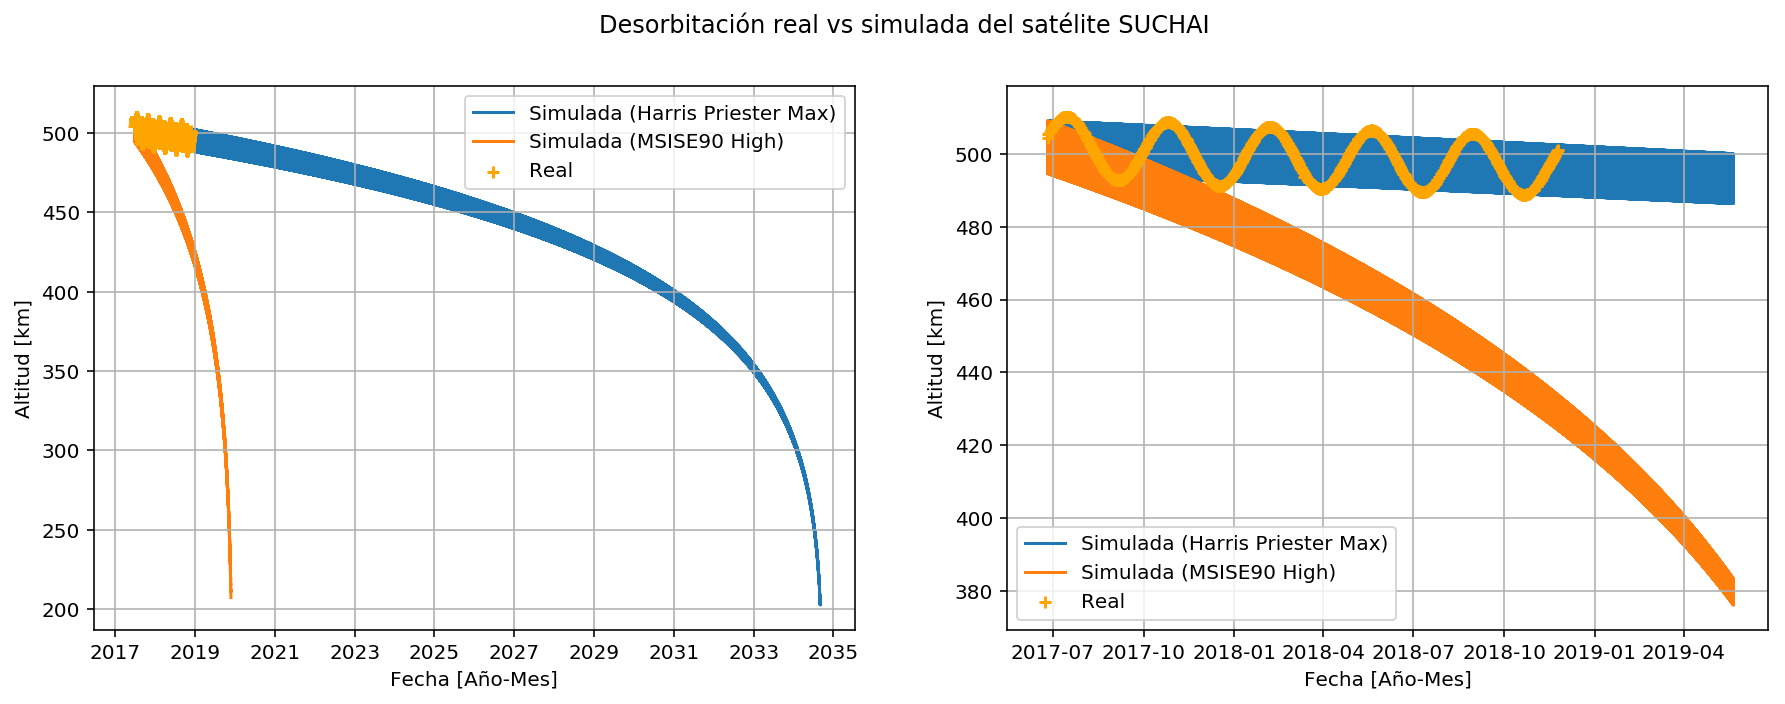

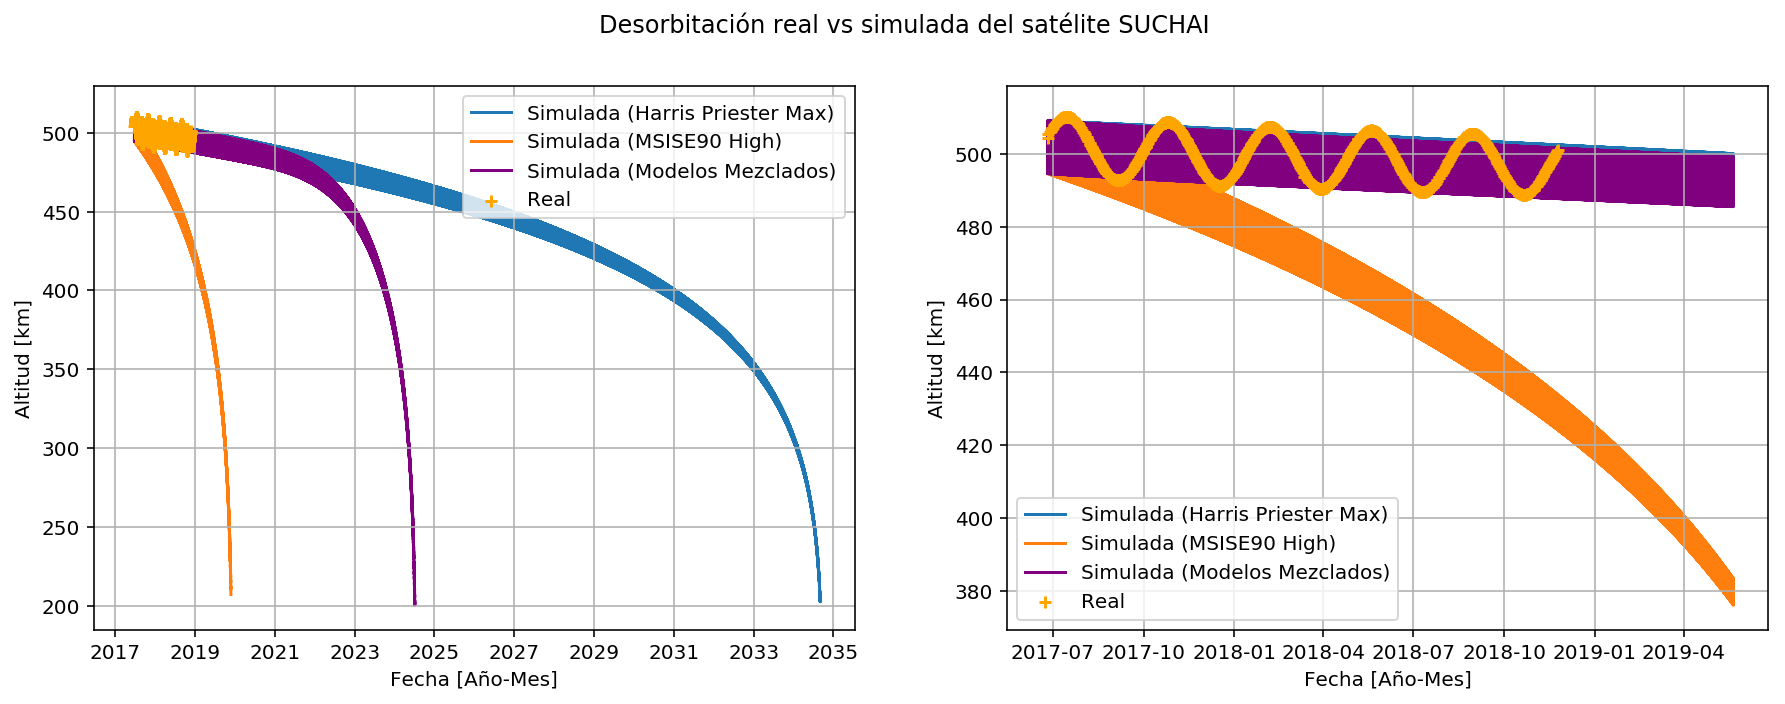

In [35]:
fig,[ax1,ax2] = plt.subplots(1,2,figsize=(15,5))
ax1.set_xlabel("Fecha [Año-Mes]")
ax1.set_ylabel("Altitud [km]")
ax1.plot(suchaiManeuvers.history.datetime,np.linalg.norm(suchaiManeuvers.history.r,axis=1)/1e3-constants.Re/1e3,zorder=1,label="Simulada (Harris Priester Max)")
ax1.plot(suchaiManeuvers2.history.datetime,np.linalg.norm(suchaiManeuvers2.history.r,axis=1)/1e3-constants.Re/1e3,zorder=1,label="Simulada (MSISE90 High)")
ax1.scatter(suchaiDates,suchaiAltitudes,marker="+",color="orange",zorder=2,label="Real");
ax1.legend(loc="upper right")
ax1.grid()
fig.suptitle("Desorbitación real vs simulada del satélite SUCHAI")
ax2.set_xlabel("Fecha [Año-Mes]")
ax2.set_ylabel("Altitud [km]")
n = 100000
ax2.plot(suchaiManeuvers.history.datetime[:n],np.linalg.norm(suchaiManeuvers.history.r[:n,:],axis=1)/1e3-constants.Re/1e3,zorder=1,label="Simulada (Harris Priester Max)")
ax2.plot(suchaiManeuvers2.history.datetime[:n],np.linalg.norm(suchaiManeuvers2.history.r[:n,:],axis=1)/1e3-constants.Re/1e3,zorder=1,label="Simulada (MSISE90 High)")
ax2.scatter(suchaiDates,suchaiAltitudes,marker="+",color="orange",zorder=2,label="Real");
ax2.legend(loc="lower left")
ax2.grid()

fig,[ax1,ax2] = plt.subplots(1,2,figsize=(15,5))
ax1.set_xlabel("Fecha [Año-Mes]")
ax1.set_ylabel("Altitud [km]")
ax1.plot(suchaiManeuvers.history.datetime,np.linalg.norm(suchaiManeuvers.history.r,axis=1)/1e3-constants.Re/1e3,zorder=1,label="Simulada (Harris Priester Max)")
ax1.plot(suchaiManeuvers2.history.datetime,np.linalg.norm(suchaiManeuvers2.history.r,axis=1)/1e3-constants.Re/1e3,zorder=1,label="Simulada (MSISE90 High)")
ax1.plot(suchaiManeuvers3.history.datetime[:-1000],np.linalg.norm(suchaiManeuvers3.history.r[:-1000,:],axis=1)/1e3-constants.Re/1e3,zorder=1,label="Simulada (Modelos Mezclados)",color="purple")
ax1.scatter(suchaiDates,suchaiAltitudes,marker="+",color="orange",zorder=2,label="Real");
ax1.legend(loc="upper right")
ax1.grid()
fig.suptitle("Desorbitación real vs simulada del satélite SUCHAI")
ax2.set_xlabel("Fecha [Año-Mes]")
ax2.set_ylabel("Altitud [km]")
n = 100000
ax2.plot(suchaiManeuvers.history.datetime[:n],np.linalg.norm(suchaiManeuvers.history.r[:n,:],axis=1)/1e3-constants.Re/1e3,zorder=1,label="Simulada (Harris Priester Max)")
ax2.plot(suchaiManeuvers2.history.datetime[:n],np.linalg.norm(suchaiManeuvers2.history.r[:n,:],axis=1)/1e3-constants.Re/1e3,zorder=1,label="Simulada (MSISE90 High)")
ax2.plot(suchaiManeuvers3.history.datetime[:n],np.linalg.norm(suchaiManeuvers3.history.r[:n,:],axis=1)/1e3-constants.Re/1e3,zorder=1,label="Simulada (Modelos Mezclados)",color="purple")
ax2.scatter(suchaiDates,suchaiAltitudes,marker="+",color="orange",zorder=2,label="Real");
ax2.legend(loc="lower left")
ax2.grid()

As we can observe from the previous figure, the <i>Harris Priester</i> atmospheric model with <i>max</i> solar intensity has a better adjustment for the available data, while the <i>MSISE90</i> model for <i>extremely high</i> solar activity does not. This kind of result, however, does not correspond with the fact that we're currently in a period of low solar activity, reaching a peak in 2025 approx. 

Therefore, more data is needed in order to make a correct prediction.